In [1]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
#print(pybamm.__version__)

In [2]:
param=pybamm.ParameterValues("Chen2020")
param['Initial inner SEI thickness [m]']=1e-13
param['Initial outer SEI thickness [m]']=1e-13
#param['Inner SEI open-circuit potential [V]']=0.25
#param

In [3]:
var_pts = {
    "x_n": 10,  # negative electrode
    "x_s": 10,  # separator 
    "x_p": 10,  # positive electrode
    "r_n": 30,  # negative particle
    "r_p": 30,  # positive particle
}

In [4]:
cycle_number =2
exp = pybamm.Experiment(
    [("Charge at C/20 until 4.2 V",
       "Rest for 20 hours",
     "Discharge at C/20 until 2.5 V",
     "Rest for 20 hours")] *cycle_number
#      +[("Charge at 0.3C  until 4.2 V", 
#       "Rest for 2 hours", 
#       "Discharge at 0.7C until 2.5 V", 
#        "Rest for 2 hours")]* cycle_number
)
#print((exp))
#print(exp.operating_conditions_cycles)
#print(exp.convert_time_to_seconds)
#pybamm.lithium_ion.DFN().variable_names()

In [5]:
#SEIModels=["reaction limited", "solvent-diffusion limited", "interstitial-diffusion limited" , "ec reaction limited"]
SEIModels=["reaction limited", "solvent-diffusion limited", "interstitial-diffusion limited"]
#SEIModels=["ec reaction limited"];
#t_eval = np.linspace(0, 4600, 600) # time in seconds
# maximum t val is 3600? don't know why? 
#for ii in np.arange(0.2,0.3,0.3):
models=[];
solutions=[]
for index in range(len(SEIModels)):
    models.append (pybamm.lithium_ion.DFN(
    { "SEI": SEIModels[index],
    "calculate discharge energy": "true",  # for compatibility with older PyBaMM versions
    }))
    #"x-average side reactions": "true"
     #sim = pybamm.Simulation(models[index], parameter_values=param, experiment=exp, var_pts=var_pts)
    solver = pybamm.CasadiSolver(mode="safe", atol=1e-6, rtol=1e-6)
    #solver = pybamm.IDAKLUSolver()
    sim = pybamm.Simulation(models[index], parameter_values=param,  var_pts=var_pts, experiment=exp,  solver=solver)
    solutions.append(sim.solve(initial_soc=0))

In [6]:
pybamm.dynamic_plot(solutions, output_variables=["X-averaged inner SEI thickness [m]", 
                     "X-averaged SEI film overpotential [V]" ,"Electrolyte potential [V]",
                                                 "X-averaged SEI film overpotential [V]" , 
                                                 "Discharge capacity [A.h]",
                                                "Terminal voltage [V]", "Power [W]",
                                                    ], 
                    labels=SEIModels,variable_limits='tight')

interactive(children=(FloatSlider(value=0.0, description='t', max=161.23340684162872, step=1.6123340684162872)…

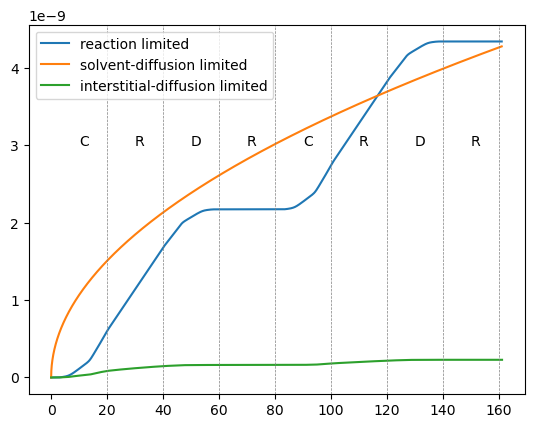

In [7]:
for index in range(len(solutions)):
    tt=solutions[index]["Time [h]"].entries
    xx=solutions[index]["X-averaged inner SEI thickness [m]"].entries
    plt.plot(tt,xx, label=SEIModels[index])
plt.legend()
a = np.sign(solutions[0]["Power [W]"].entries)
pp=solutions[0]["Power [W]"].entries
tt=solutions[0]["Time [h]"].entries
SS=["C", "R", "D", "R"]
for ii in np.arange(20,tt[-1],20):
     plt.axvline(x=ii, color='gray', linewidth=0.5, linestyle="dashed" ) # red line at x=5
     jj=(np.remainder((ii//20-1) , 4)).astype(int)
     plt.annotate(SS[jj], xy=(ii-10, 1e-9), xytext=(ii-10, 3e-9))  

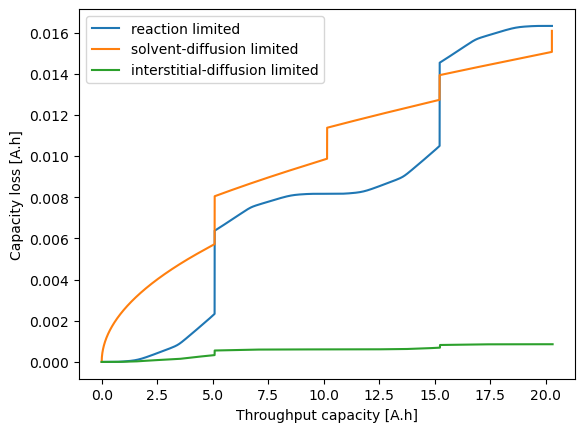

In [8]:
for index in range(len(solutions)):
    tt=solutions[index]["Time [h]"].entries
    Qt = solutions[index]["Throughput capacity [A.h]"].entries
    Q_SEI = solutions[index]["Loss of capacity to SEI [A.h]"].entries
    plt.plot(Qt, Q_SEI,label=SEIModels[index])
plt.xlabel("Throughput capacity [A.h]")
plt.ylabel("Capacity loss [A.h]")
plt.legend()
plt.show()